<center>
<h1>Introduction to Jet Images and Computer Vision</h1>

<h4>High Energy Phenomenology, Experiment and Cosmology</h4>

</center>


Material:
 1. Ben Nachman's plenary talk at ACAT 2017 (<a href="https://indico.cern.ch/event/567550/contributions/2656471/attachments/1510207/2354761/Nachman_ACAT.pdf">slides</a>)
 1. Talk on Generative Adversarial Networks for jet images at the 2017 IML Workshop (<a href="http://cds.cern.ch/record/2256878?ln=en">video</a>)
 1. Jannicke Pearkes's talk on boosted top tagging with jet images at the 2017 IML Workshop (<a href="http://cds.cern.ch/record/2256876?ln=en">video</a>)
 1. Michael Kagan's overview talk at LHCP 2017 (<a href="https://cds.cern.ch/record/2267879?ln=en">slides</a>)
 1. ATLAS PUB Note on quark vs gluon tagging with jet images(<a href="https://cds.cern.ch/record/2275641/files/ATL-PHYS-PUB-2017-017.pdf">note</a>)
 1. Lynn Huynh's summer report on jet image pre-processing (<a href="https://cds.cern.ch/record/2209127/files/Lynn_Huynh_Report.pdf">write-up</a>)
 1. Ben Nachman's talk at DataScience@LHC 2015 (<a href="http://cds.cern.ch/record/2069153">video</a>)

# Dataset

[![DOI](https://zenodo.org/badge/DOI/10.17632/4r4v785rgx.1.svg)](https://doi.org/10.17632/4r4v785rgx.1)

<a href="https://zenodo.org/record/269622#.WgZFPRNSyRs"><img src="images/zenodo.jpg"></a>

Although the dataset was released in conjunction with the arXiv publication of our [work on Generative Adversarial Networks for jet images](https://arxiv.org/pdf/1701.05927.pdf), it was previously used in the original "[Jet Images -- Deep Learning Edition](https://link.springer.com/article/10.1007%2FJHEP07%282016%29069)" work on jet image classification. Feel free to explore the dataset and use it for any project you have in mind (please cite the dataset and relevant publications explaining its generation!)

### Download dataset from Zenodo

In [1]:
import os
from keras.utils.data_utils import get_file

# Info for downloading the dataset from Zenodo
MD5_HASH = 'f9b11c46b6a0ff928bec2eccf865ecf0'
DATAFILE = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
URL_TEMPLATE = 'https://zenodo.org/record/{record}/files/{filename}'

print('[INFO] MD5 verification: {}'.format(MD5_HASH))

datafile = get_file(
    fname=DATAFILE,
    origin=URL_TEMPLATE.format(record=269622, filename=DATAFILE),
    md5_hash=MD5_HASH
)

Using TensorFlow backend.


[INFO] MD5 verification: f9b11c46b6a0ff928bec2eccf865ecf0


# Jets at the LHC

<img src="http://cms.web.cern.ch/sites/cms.web.cern.ch/files/styles/large/public/field/image/jets_v1.png?itok=ULcYw1lS">

Jets are the observable result of quarks and gluons scattering at high energy. A collimated stream of
protons and other hadrons forms in the direction of the initiating quark or gluon. Clusters of such
particles are called jets.

# Jet Images

Mature field of research! (image courtesy of B.P.Nachman) 
<img src="./images/graph.jpg" width="800">
<a href="https://arxiv.org/abs/1709.04464"><img src="./images/jet.jpg" width="600" align="right" style="border:5px solid black"></a>


### What is a jet image?

<img src="./images/jet_image.jpg" width="300">

> A jet image is a two-dimensional representation of the radiation pattern within a jet: the distribution of the locations and energies of the jet’s constituent particles. The jet image consists of a regular grid of pixels in η×φ. 

Advantages of this data format include: easy visual inspection, fixed-length representation, suitable for application of computer vision techniques.

### Pre-processing

In the dataset we will be using today:

> The finite granularity of a calorimeter is simulated with a regular 0.1×0.1 grid in η and φ. The energy of each calorimeter cell is given by the sum of the energies of all particles incident on the cell. Cells with positive energy are assigned to jets using the anti-kt clustering algorithm with a radius parameter of R = 1.0 via the software package FastJet 3.2.1.

> To mitigate the contribution from the underlying event, jets are are trimmed by re-clustering the constituents into R = 0.3 kt subjets and dropping those which have less than 5% of the transverse momentum of the parent jet. Trimming also reduces the impact of pileup: multiple proton-proton collisions occurring in the same event as the hard-scatter process. Jet images are formed by translating the η and φ of all constituents of a given jet so that its highest pT subjet is centered at the origin.

> A rectangular grid of η × φ ∈ [−1.25, 1.25] × [−1.25, 1.25] with 0.1 × 0.1 pixels centered at the origin
forms the basis of the jet image. The intensity of each pixel is the pT corresponding to the energy
and pseudorapditiy of the constituent calorimeter cell, pT = E_cell/ cosh(η_cell). The radiation pattern
is symmetric about the origin of the jet image and so the images are rotated. The subjet with the
second highest pT (or, in its absence, the direction of the first principle component) is placed at an
angle of −π/2 with respect to the η − φ axes. Finally, a parity transform about the vertical axis is
applied if the left side of the image has more energy than the right side.

<div align="right">
  <i>Learning Particle Physics by Example: Location-Aware Generative Adversarial Networks for Physics Synthesis</i> <br>
  [arXiv:1701.05927](https://arxiv.org/pdf/1701.05927.pdf)
</div>

References: 
* Section 3 of [arXiv:1511.05190](https://link.springer.com/content/pdf/10.1007%2FJHEP07%282016%29069.pdf)
* <a href="https://link.springer.com/article/10.1007/s41781-017-0004-6#Sec16">Appendix B</a> of [arXiv:1701.05927](https://arxiv.org/pdf/1701.05927.pdf)

### Uniqueness with respect to natural images in ML literature

* Sparse (low occupancy)
* High dynamic range (pixel intensity represents pT of particles and spans several orders of magnitude)
* Pixel activations and positions are physically meaningful
* Small variations can drastically modify physical properties of a jet

# Hands-on tutorial

In [3]:
import h5py
import numpy as np
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [4]:
# number of images to load
nb_points = 800000

In [6]:
# open hdf5 data file
d = h5py.File(datafile, 'r')

In [7]:
# content of the dataset
d.items()

[(u'image', <HDF5 dataset "image": shape (872666, 25, 25), type "<f4">),
 (u'jet_delta_R', <HDF5 dataset "jet_delta_R": shape (872666,), type "<f4">),
 (u'jet_eta', <HDF5 dataset "jet_eta": shape (872666,), type "<f4">),
 (u'jet_mass', <HDF5 dataset "jet_mass": shape (872666,), type "<f4">),
 (u'jet_phi', <HDF5 dataset "jet_phi": shape (872666,), type "<f4">),
 (u'jet_pt', <HDF5 dataset "jet_pt": shape (872666,), type "<f4">),
 (u'signal', <HDF5 dataset "signal": shape (872666,), type "<f4">),
 (u'tau_1', <HDF5 dataset "tau_1": shape (872666,), type "<f4">),
 (u'tau_2', <HDF5 dataset "tau_2": shape (872666,), type "<f4">),
 (u'tau_21', <HDF5 dataset "tau_21": shape (872666,), type "<f4">),
 (u'tau_3', <HDF5 dataset "tau_3": shape (872666,), type "<f4">),
 (u'tau_32', <HDF5 dataset "tau_32": shape (872666,), type "<f4">)]

In [8]:
# extract a random subset of samples
ix = range(d['image'].shape[0]) # get indices
np.random.shuffle(ix) # shuffle them
ix = ix[:nb_points] # select out nb_points

# extract data from dataset
images, labels = d['image'][:][ix], d['signal'][:][ix]
mass = d['jet_mass'][:][ix]
delta_R = d['jet_delta_R'][:][ix]
tau_21 = d['tau_21'][:][ix]

You can compute the quantities above directly from the images:

\begin{align}
&p_\text{T}^2(I) =\left(\sum_{i=0}^{N} I_i\cos(\phi_i)\right)^2+\left(\sum_{i=0}^{N} I_i\sin(\phi_i)\right)^2
\label{eq:pt}
\\
&m^2(I) = \left(\sum_{i=0}^{N} I_i\right)^2-p_\text{T}^2(I)-\left(\sum_{i=0}^{N} I_i\sinh(\eta_i)\right)^2
\label{eq:m}
\\
&\tau_{21}(I)=\frac{\tau_2(I)}{\tau_1(I)},
\label{eq:tau21}
\end{align}
where:
\begin{equation*}
\tau_{n}(I)\propto\sum_{i=0}^{N} I_i \min_{1\leq a\leq n}\left\{\sqrt{\left(\eta_i-\eta_a\right)^2+\left(\phi_i-\phi_a\right)^2}\right\}
\end{equation*}

In [9]:
def plot_jet_image(content, output_fname=None, vmin=1e-6, vmax=300, title=''):
    '''
    Function to help you visualize a jet image on a log scale
    Args:
    -----
        content : numpy array of dimensions 25x25, first arg to imshow, 
            content of the image
            e.g.: images.mean(axis=0) --> the average image

        output_fname : string, name of the output file where the plot will be 
            saved. 

        vmin : (default = 1e-6) float, lower bound of the pixel intensity 
            scale before saturation

        vmax : (default = 300) float, upper bound of the pixel intensity 
            scale before saturation

        title : (default = '') string, title of the plot, to be displayed 
            on top of the image
    '''
    fig, ax = plt.subplots(figsize=(7, 6))
    extent = [-1.25, 1.25, -1.25, 1.25]

    im = ax.imshow(content, interpolation='nearest',
                   norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent)

    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)

    if output_fname is None:
        plt.savefig(output_fname)

In [10]:
def plot_diff_jet_image(content, output_fname=None, extr=None, title='',
                        cmap=matplotlib.cm.seismic):
    '''
    Function to help you visualize the difference between two sets of jet 
        images on a linear scale
    Args:
    -----
        content : numpy array of dimensions 25x25, first arg to imshow, 
            content of the image
            e.g.: sig_images.mean(axis=0) - bkg_images.mean(axis=0)
        output_fname : string, name of the output file where the plot will be 
            saved.
        extr : (default = None) float, magnitude of the upper and lower 
            bounds of the pixel intensity scale before saturation (symmetric 
            around 0)
        title : (default = '') string, title of the plot, to be displayed on 
            top of the image
        cmap : (default = matplotlib.cm.PRGn_r) matplotlib colormap, ideally 
            white in the middle
    '''
    fig, ax = plt.subplots(figsize=(6, 6))
    extent = [-1.25, 1.25, -1.25, 1.25]
    if extr == None:
        extr = max(abs(content.min()), abs(content.max()))
    im = ax.imshow(
        content,
        interpolation='nearest',
        norm=Normalize(vmin=-extr, vmax=+extr), extent=extent,
        cmap=cmap
    )

    plt.colorbar(im, fraction=0.05, pad=0.05)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)

    if output_fname:
        plt.savefig(output_fname)


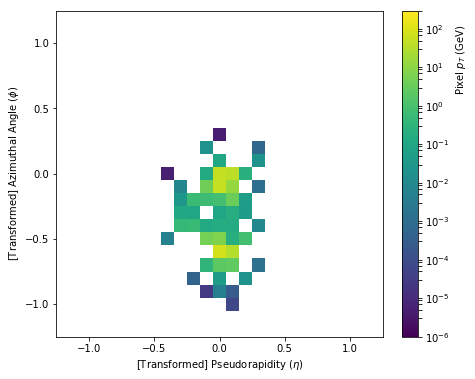

In [11]:
# visualize a jet image
plot_jet_image(images[0])

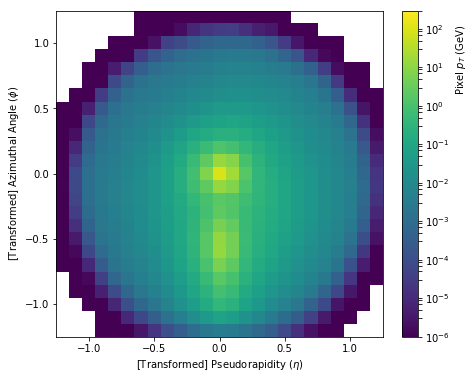

In [12]:
# visualize the average jet image
plot_jet_image(images.mean(axis=0))

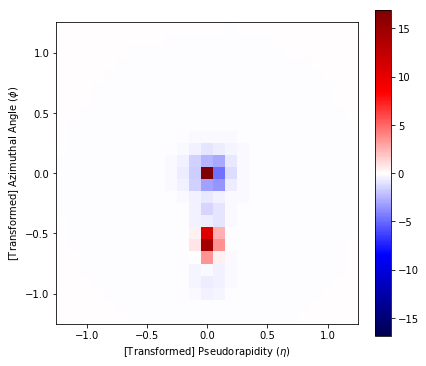

In [13]:
# visualize the difference between the average signal and the average background image
plot_diff_jet_image(
    images[labels == 1].mean(axis=0) - images[labels == 0].mean(axis=0)
)

## Looking at Physics features

In [14]:
def plot_physics_feature(feature_name, feature, labels, bins=None, output_fname=None):

    # if bins are not defined when function is called, define them here
    if not bins:
        bins = np.linspace(feature.min(), feature.max(), 50)

    fig, ax = plt.subplots(figsize=(6, 6))

    _ = plt.hist(feature[labels == 1], bins=bins, histtype='step',
                 label=r"Signal ($W' \rightarrow WZ$)",
                 normed=True, color='red')

    _ = plt.hist(feature[labels == 0], bins=bins, histtype='step',
                 label=r'Background (QCD dijets)', normed=True, color='blue')

    plt.xlabel(r'Discretized {} of Jet Image'.format(feature_name))
    plt.ylabel(r'Units normalized to unit area')
    plt.legend()

    if output_fname:
        plt.savefig(output_fname)


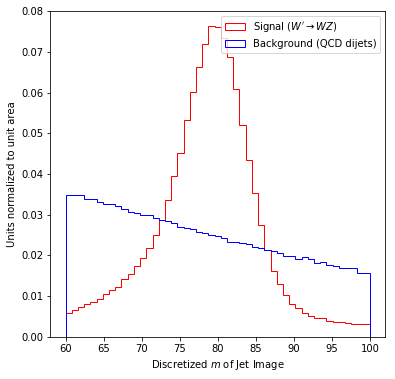

In [15]:
plot_physics_feature(r'$m$', mass, labels)

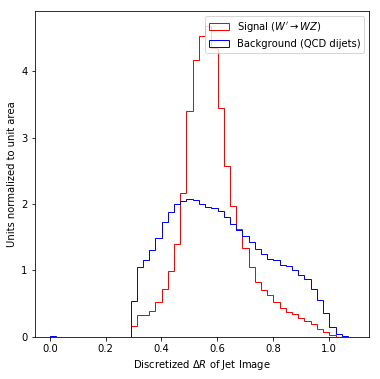

In [16]:
plot_physics_feature(r'$\Delta R$', delta_R, labels)

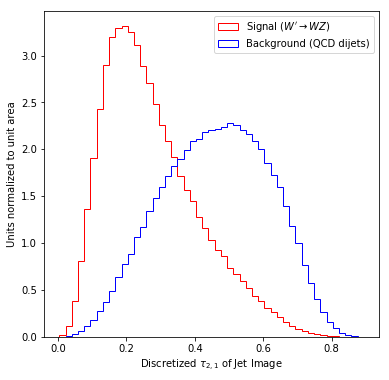

In [17]:
plot_physics_feature(r'$\tau_{2,1}$', tau_21, labels)

# Jet Image Classification

We can now try to use various techniques to classify the jet images into signal (i.e. originating from boosted W bosons) and background (QCD).

We will start with a classic feature-based classifier, which will use properties of the jet such as mass, tau_21, and delta_R (known to have good discriminative power) to separate the two classes.

Then, we will construct different networks that operate directly at the pixel level and compare them all.

## Simple feature-based classifier

#### Data processing

Follow the procedure from yesterday to create your matrix of features X. Shuffle its entries, split them into train, test, and validation set, and scale them to zero mean and unit standard deviation.

In [19]:
features = np.stack((mass, tau_21, delta_R)).T # What we called X yesterday

In [20]:
features

array([[  8.32666473e+01,   2.04822451e-01,   5.39974034e-01],
       [  8.12588806e+01,   1.50861815e-01,   7.13163793e-01],
       [  9.46128769e+01,   4.19182539e-01,   4.54179347e-01],
       ..., 
       [  6.23480110e+01,   6.62943900e-01,   5.78597903e-01],
       [  8.06691437e+01,   8.02331641e-02,   6.24256849e-01],
       [  6.91418457e+01,   4.10301745e-01,   7.06015885e-01]], dtype=float32)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# 80% train+validate, 20% test
images_train, images_test, \
    labels_train, labels_test, \
    features_train, features_test \
    = train_test_split(images, labels, features,
                       test_size=0.2)

# 64% train, 16% validate
images_train, images_val, \
    labels_train, labels_val, \
    features_train, features_val \
    = train_test_split(images_train, labels_train, features_train,
                       test_size=0.2)

In [23]:
print ('{} training samples\n{} validation samples\n{} testing samples'
       .format(images_train.shape[0], images_val.shape[0], images_test.shape[0]))

512000 training samples
128000 validation samples
160000 testing samples


In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_val = scaler.transform(features_val)
features_test = scaler.transform(features_test)

#### Model

Build a simple keras model made of fully-connected (Dense) layers. Remember the steps:
1. Define the symbolic graph by connecting layers
1. Define an optimizer and a loss function to minimize
1. Train ('fit') the model to the training dataset, monitoring whether the validation loss continues to decrease
1. Stop the training automatically when the validation loss stops going down
1. Evaluate performance on test set

Recall activation functions: Rectified Linear Unit (relu) vs. Leaky Rectified Linear Unit
<img src="https://cdn-images-1.medium.com/max/1600/1*A_Bzn0CjUgOXtPCJKnKLqA.jpeg">

In [26]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [27]:
x = Input(shape=(features_train.shape[1], ))
h = Dense(64, activation='relu')(x)
h = Dense(64, activation='relu')(h)
h = Dense(64, activation='relu')(h)
y = Dense(1, activation='sigmoid')(h)

In [28]:
baseline_model = Model(x, y)
baseline_model.compile('adam', 'binary_crossentropy', metrics=['acc'])

The command below trains the model. However, in the interest of time, I will not train the network on the spot. I will instead load in pre-trained weights from a training I performed last night.

In [127]:
# baseline_model.fit(
#     features_train, labels_train, # X and y
#     epochs=200,
#     batch_size=128,
#     validation_data=(features_val, labels_val), # validation X and y
#     callbacks=[
#         EarlyStopping(verbose=True, patience=15, monitor='val_loss'),
#         ModelCheckpoint('./models/baseline-model.h5', monitor='val_loss',
#                         verbose=True, save_best_only=True)
#     ]
# )

Train on 512000 samples, validate on 128000 samples
Epoch 1/200
512000/512000 [==============================] - 20s 39us/step - loss: 0.4542 - acc: 0.7907 - val_loss: 0.4535 - val_acc: 0.7908
Epoch 2/200
512000/512000 [==============================] - 20s 39us/step - loss: 0.4515 - acc: 0.7923 - val_loss: 0.4527 - val_acc: 0.7908
Epoch 3/200
512000/512000 [==============================] - 19s 38us/step - loss: 0.4510 - acc: 0.7925 - val_loss: 0.4522 - val_acc: 0.7916
Epoch 4/200
512000/512000 [==============================] - 20s 38us/step - loss: 0.4508 - acc: 0.7929 - val_loss: 0.4519 - val_acc: 0.7913
Epoch 5/200
512000/512000 [==============================] - 18s 35us/step - loss: 0.4506 - acc: 0.7928 - val_loss: 0.4518 - val_acc: 0.7916
Epoch 6/200
512000/512000 [==============================] - 20s 38us/step - loss: 0.4504 - acc: 0.7928 - val_loss: 0.4527 - val_acc: 0.7908
Epoch 7/200
512000/512000 [==============================] - 19s 37us/step - loss: 0.4504 - acc: 0.792

If you were to actually run the training, you would be able to visualize its history. Keras saves the entire training history, keeping track of whatever metric you specify (here accuracy and loss).

In [128]:
history = baseline_model.history.history
history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

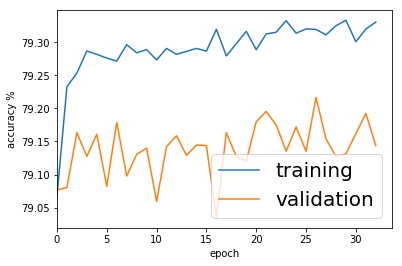

In [129]:
# accuracy plot
plt.plot(100 * np.array(history['acc']), label='training')
plt.plot(100 * np.array(history['val_acc']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)
plt.show()

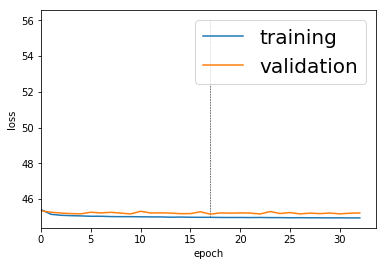

In [130]:
# loss plot
plt.plot(100 * np.array(history['loss']), label='training')
plt.plot(100 * np.array(history['val_loss']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right', fontsize=20)
# the line indicate the epoch corresponding to the best performance on the validation set
# plt.vlines(np.argmin(history['val_loss']), 45, 56, linestyle='dashed', linewidth=0.5)
plt.show()

In [131]:
print 'Loss estimate on unseen examples (from validation set) = {0:.3f}'.format(np.min(history['val_loss']))

Loss estimate on unseen examples (from validation set) = 0.452


#### Evaluate on test set

In [30]:
baseline_model.load_weights('./models/baseline-model.h5')

In [31]:
yhat_baseline = baseline_model.predict(features_test, batch_size=512)

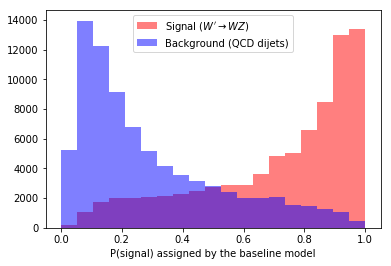

In [34]:
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat_baseline[labels_test==1],
         histtype='stepfilled', alpha=0.5, color='red', label=r"Signal ($W' \rightarrow WZ$)", bins=bins)
_ = plt.hist(yhat_baseline[labels_test==0],
         histtype='stepfilled', alpha=0.5, color='blue', label=r'Background (QCD dijets)', bins=bins)
plt.legend(loc='upper center')
plt.xlabel('P(signal) assigned by the baseline model')

## Convolutional Neural Network

We can now instead try to learn a model directly on the pixel space, instead of summarizing the information into engineered features such as mass, tau_21 and delta_R.

In [38]:
from keras.layers import Conv2D, Flatten, LeakyReLU

In [36]:
# add channel dimension (1 for grayscale)
images_train = np.expand_dims(images_train, -1)
images_test = np.expand_dims(images_test, -1)
images_val = np.expand_dims(images_val, -1)

In [39]:
x = Input(shape=(images_train.shape[1:]))
h = Conv2D(32, kernel_size=7, strides=1)(x)
h = LeakyReLU()(h)
h = Dropout(0.2)(h)

h = Conv2D(64, kernel_size=7, strides=1)(h)
h = LeakyReLU()(h)
h = Dropout(0.2)(h)

h = Conv2D(128, kernel_size=5, strides=1)(h)
h = LeakyReLU()(h)
h = Dropout(0.2)(h)

h = Conv2D(256, kernel_size=5, strides=1)(h)
h = LeakyReLU()(h)
h = Flatten()(h)
h = Dropout(0.2)(h)
y = Dense(1, activation='sigmoid')(h)

In [40]:
cnn_model = Model(x, y)
cnn_model.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [41]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        1600      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        100416    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
__________

Feel free to try to train it at home! For this tutorial, we will just load in pre-trained weights.

In [316]:
# cnn_model.fit(
#     images_train, labels_train,
#     epochs=100,
#     batch_size=512,
#     validation_data=(images_val, labels_val),
#     callbacks=[
#         EarlyStopping(verbose=True, patience=30, monitor='val_loss'),
#         ModelCheckpoint('./models/cnn-model.h5', monitor='val_loss',
#                         verbose=True, save_best_only=True)
#     ]
# )

Train on 512000 samples, validate on 128000 samples
Epoch 1/100
512000/512000 [==============================] - 46s 90us/step - loss: 0.5147 - acc: 0.7598 - val_loss: 0.4759 - val_acc: 0.7780
Epoch 2/100
512000/512000 [==============================] - 43s 85us/step - loss: 0.4625 - acc: 0.7878 - val_loss: 0.4351 - val_acc: 0.8033
Epoch 3/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4533 - acc: 0.7944 - val_loss: 0.4456 - val_acc: 0.7955
Epoch 4/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4475 - acc: 0.7965 - val_loss: 0.4253 - val_acc: 0.8080
Epoch 5/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4427 - acc: 0.7996 - val_loss: 0.4201 - val_acc: 0.8126
Epoch 6/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4387 - acc: 0.8014 - val_loss: 0.4454 - val_acc: 0.7985
Epoch 7/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4373 - acc: 0.802

Epoch 30/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4291 - acc: 0.8068 - val_loss: 0.4011 - val_acc: 0.8229
Epoch 31/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4275 - acc: 0.8078 - val_loss: 0.4368 - val_acc: 0.7985
Epoch 32/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4285 - acc: 0.8076 - val_loss: 0.4091 - val_acc: 0.8182
Epoch 33/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4290 - acc: 0.8072 - val_loss: 0.4333 - val_acc: 0.8011
Epoch 34/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4289 - acc: 0.8069 - val_loss: 0.4085 - val_acc: 0.8182
Epoch 35/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4285 - acc: 0.8070 - val_loss: 0.4461 - val_acc: 0.7996
Epoch 36/100
512000/512000 [==============================] - 44s 86us/step - loss: 0.4280 - acc: 0.8077 - val_loss: 0.4274 - val_acc: 0.8063
Epoch 

KeyboardInterrupt: 

In [317]:
cnn_history = cnn_model.history.history

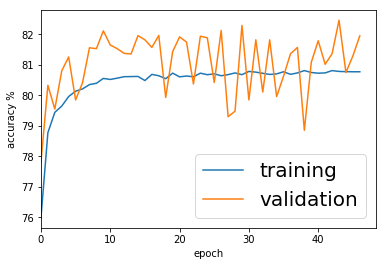

In [318]:
# accuracy plot
plt.plot(100 * np.array(cnn_history['acc']), label='training')
plt.plot(100 * np.array(cnn_history['val_acc']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)
plt.show()

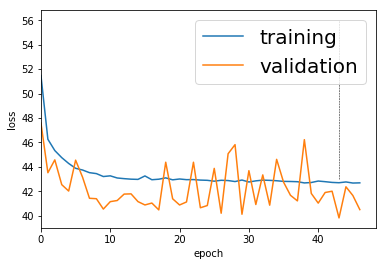

In [319]:
# loss plot
plt.plot(100 * np.array(cnn_history['loss']), label='training')
plt.plot(100 * np.array(cnn_history['val_loss']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right', fontsize=20)
# the line indicate the epoch corresponding to the best performance on the validation set
plt.vlines(np.argmin(cnn_history['val_loss']), 43, 56, linestyle='dashed', linewidth=0.5)
plt.show()

In [320]:
print 'Loss estimate on unseen examples (from validation set) = {0:.3f}'.format(np.min(cnn_history['val_loss']))

Loss estimate on unseen examples (from validation set) = 0.398


In [58]:
cnn_model.load_weights('models/cnn-model.h5')
yhat_cnn = cnn_model.predict(images_test, batch_size=512, verbose=True)

160000/160000 [==============================] - 585s 4ms/step


## Locally-Connected Neural Network

In [45]:
from keras.layers import LocallyConnected2D , MaxPool2D, Flatten

In [46]:
x = Input(shape=(images_train.shape[1:]))
h = LocallyConnected2D(32, kernel_size=9, strides=2)(x)
h = LeakyReLU()(h)

h = Dropout(0.2)(h)
h = LocallyConnected2D(32, kernel_size=5, strides=1)(h)
h = LeakyReLU()(h)

h = Dropout(0.2)(h)
h = LocallyConnected2D(64, kernel_size=3, strides=1)(h)
h = LeakyReLU()(h)

h = Dropout(0.2)(h)
h = LocallyConnected2D(64, kernel_size=3, strides=1)(h)
h = LeakyReLU()(h)

h = Flatten()(h)
h = Dropout(0.2)(h)
y = Dense(1, activation='sigmoid')(h)

In [47]:
lcn_model = Model(x, y)
lcn_model.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [48]:
lcn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 25, 25, 1)         0         
_________________________________________________________________
locally_connected2d_1 (Local (None, 9, 9, 32)          212544    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
locally_connected2d_2 (Local (None, 5, 5, 32)          640800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 32)          0         
__________

Feel free to try to train it at home! For this tutorial, we will just load in pre-trained weights.

In [284]:
# lcn_model.fit(
#     images_train, labels_train,
#     epochs=100,
#     batch_size=256,
#     validation_data=(images_val, labels_val),
#     callbacks=[
#         EarlyStopping(verbose=True, patience=30, monitor='val_loss'),
#         ModelCheckpoint('./models/lcn-model.h5', monitor='val_loss',
#                         verbose=True, save_best_only=True)
#     ]
# )

Train on 512000 samples, validate on 128000 samples
Epoch 1/100
512000/512000 [==============================] - 28s 55us/step - loss: 0.4491 - acc: 0.7967 - val_loss: 0.4267 - val_acc: 0.8105
Epoch 2/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.4238 - acc: 0.8107 - val_loss: 0.4144 - val_acc: 0.8160
Epoch 3/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.4183 - acc: 0.8137 - val_loss: 0.4118 - val_acc: 0.8183
Epoch 4/100
512000/512000 [==============================] - 25s 49us/step - loss: 0.4149 - acc: 0.8162 - val_loss: 0.4065 - val_acc: 0.8198
Epoch 5/100
512000/512000 [==============================] - 25s 49us/step - loss: 0.4120 - acc: 0.8172 - val_loss: 0.4009 - val_acc: 0.8234
Epoch 6/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.4101 - acc: 0.8184 - val_loss: 0.4043 - val_acc: 0.8217
Epoch 7/100
512000/512000 [==============================] - 25s 50us/step - loss: 0.4082 - acc: 0.819

Epoch 30/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.3933 - acc: 0.8277 - val_loss: 0.3912 - val_acc: 0.8290
Epoch 31/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.3925 - acc: 0.8280 - val_loss: 0.3900 - val_acc: 0.8295
Epoch 32/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.3927 - acc: 0.8277 - val_loss: 0.3967 - val_acc: 0.8250
Epoch 33/100
512000/512000 [==============================] - 25s 49us/step - loss: 0.3923 - acc: 0.8279 - val_loss: 0.3950 - val_acc: 0.8251
Epoch 34/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.3925 - acc: 0.8279 - val_loss: 0.3935 - val_acc: 0.8280
Epoch 35/100
512000/512000 [==============================] - 26s 50us/step - loss: 0.3911 - acc: 0.8285 - val_loss: 0.4002 - val_acc: 0.8247
Epoch 36/100
512000/512000 [==============================] - 26s 51us/step - loss: 0.3912 - acc: 0.8289 - val_loss: 0.3929 - val_acc: 0.8282
Epoch 

KeyboardInterrupt: 

In [285]:
lcn_history = lcn_model.history.history

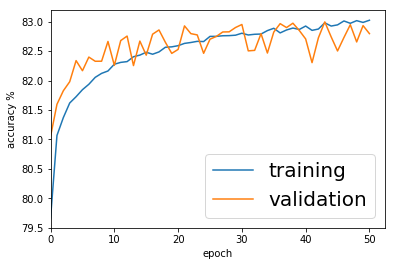

In [286]:
# accuracy plot
plt.plot(100 * np.array(lcn_history['acc']), label='training')
plt.plot(100 * np.array(lcn_history['val_acc']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)
plt.show()

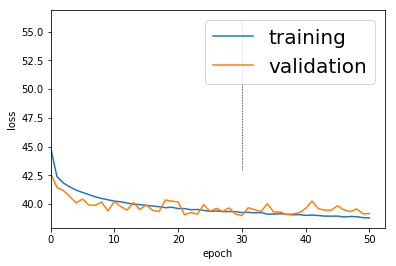

In [287]:
# loss plot
plt.plot(100 * np.array(lcn_history['loss']), label='training')
plt.plot(100 * np.array(lcn_history['val_loss']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right', fontsize=20)
# the line indicate the epoch corresponding to the best performance on the validation set
plt.vlines(np.argmin(lcn_history['val_loss']), 43, 56, linestyle='dashed', linewidth=0.5)
plt.show()

In [288]:
print 'Loss estimate on unseen examples (from validation set) = {0:.3f}'.format(np.min(lcn_history['val_loss']))

Loss estimate on unseen examples (from validation set) = 0.390


In [50]:
lcn_model.load_weights('models/lcn-model.h5')
yhat_lcn = lcn_model.predict(images_test, batch_size=512)

## Fully-Connected network

In [51]:
x = Input(shape=(images_train.shape[1:]))
h = Flatten()(x)
h = Dense(25 ** 2, kernel_initializer='he_normal')(h)
h = LeakyReLU()(h)

h = Dropout(0.2)(h)
h = Dense(512, kernel_initializer='he_normal')(h)
h = LeakyReLU()(h)

h = Dropout(0.2)(h)
h = Dense(256, kernel_initializer='he_normal')(h)
h = LeakyReLU()(h)

h = Dropout(0.2)(h)
h = Dense(128, kernel_initializer='he_normal')(h)
h = LeakyReLU()(h)

h = Dropout(0.2)(h)
y = Dense(1, activation='sigmoid')(h)

In [52]:
dense_model = Model(x, y)
dense_model.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [53]:
# dense_model.fit(
#     images_train, labels_train,
#     epochs=100,
#     batch_size=256,
#     validation_data=(images_val, labels_val),
#     callbacks=[
#         EarlyStopping(verbose=True, patience=30, monitor='val_loss'),
#         ModelCheckpoint('./models/dense-model.h5', monitor='val_loss',
#                         verbose=True, save_best_only=True)
#     ]
# )

In [302]:
dense_history = dense_model.history.history

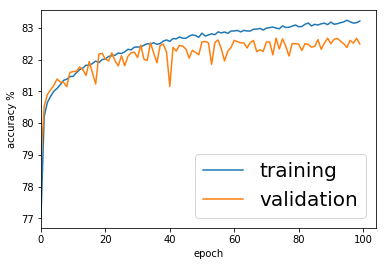

In [303]:
# accuracy plot
plt.plot(100 * np.array(dense_history['acc']), label='training')
plt.plot(100 * np.array(dense_history['val_acc']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)
plt.show()

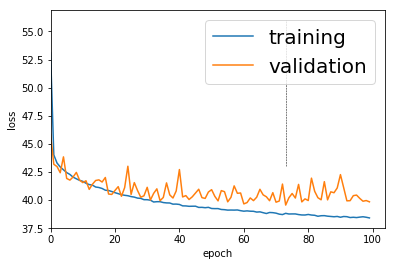

In [304]:
# loss plot
plt.plot(100 * np.array(dense_history['loss']), label='training')
plt.plot(100 * np.array(dense_history['val_loss']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right', fontsize=20)
# the line indicate the epoch corresponding to the best performance on the validation set
plt.vlines(np.argmin(dense_history['val_loss']), 43, 56, linestyle='dashed', linewidth=0.5)
plt.show()

In [305]:
print 'Loss estimate on unseen examples (from validation set) = {0:.3f}'.format(np.min(dense_history['val_loss']))

Loss estimate on unseen examples (from validation set) = 0.396


In [55]:
dense_model.load_weights('models/dense-model.h5')
yhat_dense = dense_model.predict(images_test, batch_size=512, verbose=True)

160000/160000 [==============================] - 11s 69us/step


## Plot ROC Curves

A standard way to visualize the tradeoff between low false positive rate (FPR) and high true positive rate (TPR) is by plotting them on a ROC curve. In Physics, people like to plot the TPR on the x-axis, and 1/FPR on the y-axis.

In [307]:
from sklearn.metrics import roc_curve

In [322]:
fpr_cnn, tpr_cnn, _ = roc_curve(labels_test, yhat_cnn)
fpr_lcn, tpr_lcn, _ = roc_curve(labels_test, yhat_lcn)
fpr_dense, tpr_dense, _ = roc_curve(labels_test, yhat_dense)
fpr_baseline, tpr_baseline, _ = roc_curve(labels_test, yhat_baseline)

/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


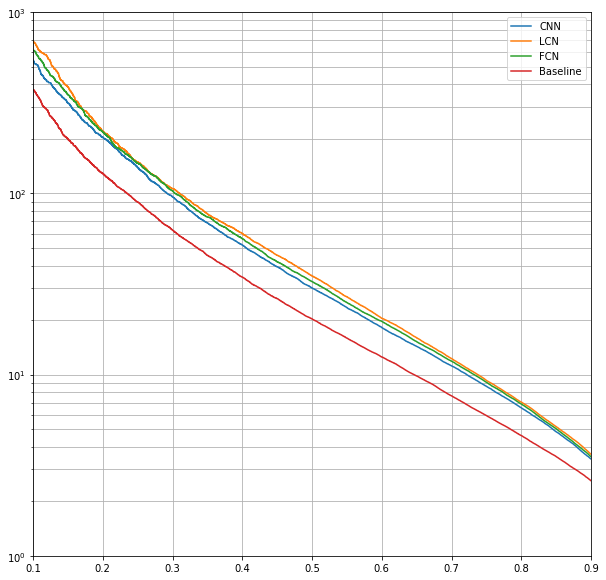

In [323]:
plt.figure(figsize=(10,10))
plt.grid(b = True, which = 'minor')
plt.grid(b = True, which = 'major')
_ = plt.plot(tpr_cnn, 1./fpr_cnn, label='CNN')
_ = plt.plot(tpr_lcn, 1./fpr_lcn, label='LCN')
_ = plt.plot(tpr_dense, 1./fpr_dense, label='FCN')
_ = plt.plot(tpr_baseline, 1./fpr_baseline, label='Baseline')
plt.legend()
plt.xlim((0.1, 0.9))
plt.ylim((1, 1000))
plt.yscale('log')

## What is the network learning?

In [56]:
def get_correlations(images, disc_output):
    '''
    calculate linear correlation between each pixel and the output of the classifier
    to see what pixels are more indicative of a specific class.
    '''
    import pandas as pd
    # -- find the total number of pixels per image, here 25 x 25
    n_pixels = np.prod(images.shape[1:3])
    
    # -- add the pixels as columns to a dataframe
    df = pd.DataFrame(
        {i : np.squeeze(images).reshape(-1, n_pixels)[:, i] for i in range(n_pixels)}
    )
    # -- add a column to the end of the dataframe for the discriminator's output
    df['disc_output'] = disc_output
    # -- pandas offers an easy solution to calculate correlations 
    # (even though it's slow because it also calculates the correlation between each pixel and every other pixel)
    correlations = df.corr().values[:-1, -1]
    return correlations

def plot_correlations(correlations, extent, title='', img_dim=(25, 25), cmap=plt.cm.seismic):
    '''
    call the function about and then plot the correlations in image format
    '''
    max_mag = max(
        abs(np.min(correlations[np.isfinite(correlations)])),
        abs(np.max(correlations[np.isfinite(correlations)])),
    ) # highest correlation value (abs value), to make the plot look nice and on a reasonable scale

    f, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(
        correlations.reshape(img_dim),
        interpolation='nearest',
        norm=Normalize(vmin=-max_mag, vmax=max_mag),
        extent=extent,
        cmap=cmap
    )
    
    plt.colorbar(im, fraction=0.05, pad=0.05)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)
#     plt.savefig(os.path.join('..', outdir, outname))

You can now visualize what each network picks up on, at least to first order. These correlation plots tells us whether a specific pixel being strongly activated is a good indicator of that jet image belonging to a class or the other. Red represents the signal (boosted W from W'-->WZ), blue represents the background (QCD).

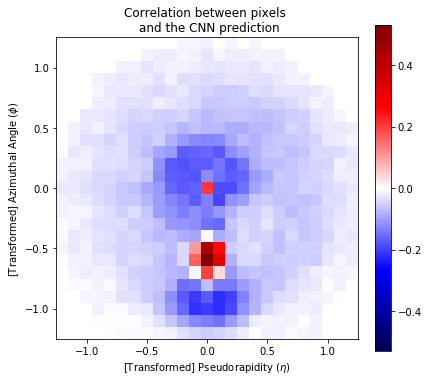

In [59]:
plot_correlations(
    get_correlations(images_test[:10000], yhat_cnn[:10000]),
    extent=[-1.25, 1.25, -1.25, 1.25],
    title='Correlation between pixels \n and the CNN prediction'
)

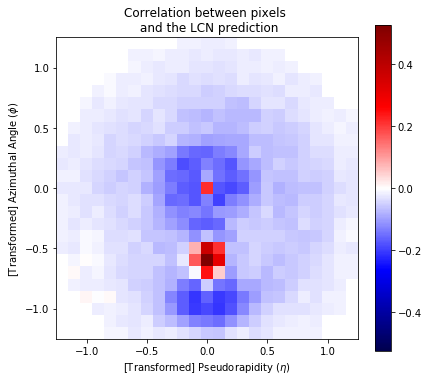

In [202]:
plot_correlations(
    get_correlations(images_test[:10000], yhat_lcn[:10000]),
    extent=[-1.25, 1.25, -1.25, 1.25],
    title='Correlation between pixels \n and the LCN prediction'
)

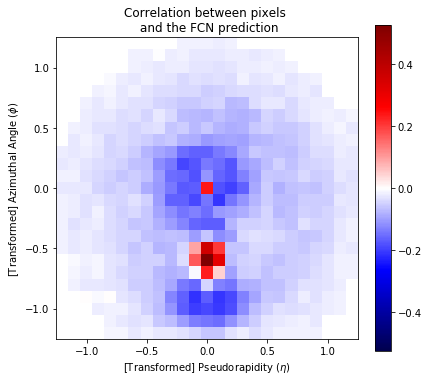

In [203]:
plot_correlations(
    get_correlations(images_test[:10000], yhat_dense[:10000]),
    extent=[-1.25, 1.25, -1.25, 1.25],
    title='Correlation between pixels \n and the FCN prediction'
)

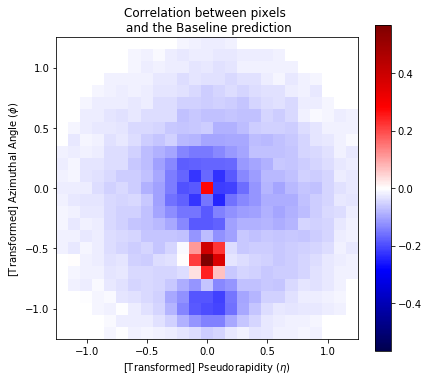

In [204]:
plot_correlations(
    get_correlations(images_test[:10000], yhat_baseline[:10000]),
    extent=[-1.25, 1.25, -1.25, 1.25],
    title='Correlation between pixels \n and the Baseline prediction'
)

You can also look at how the output of each classifier is correlated with known quantities that are known to be discriminative, such as the ones used in the baseline classifier above (mass, tau_21, delta_R). This will inform us as to whether the network has 'learned' to internally calculate a representation that is close to these variables, thus eliminating our need to come up with these features ourselves.

In [60]:
def plot_output_vs_kin(kin, output, xlabel, ylabel, nbins=30):
    '''
    Plot one output of the discriminator network vs. one of the 1D physics variables that describe jets
    Args:
    -----
        kin : numpy array, kinematic property (such as mass or pT) associated with each image. I.e.: discrete_mass(np.squeeze(generated_images))
        output : numpy array, one of the 2 outputs of the discriminator, evaluated on the same images that `kin` refers to
        xlabel : string, x-axis label that describes the meaning of `kin`
        ylabel : string, y-axis label that describes the meaning og `output`
        outname : name of the output file, to be placed in ../plots/
        nbins : (default = 30) number of bins to use to represent the distributions in a discretized way
    
    '''
    # set the colormap
    plt.set_cmap('jet')
    # draw a 2d histogram of the discriminator's output versus the kinematic variable of choice (mass, pT, etc.)
    h, binx, biny, _ = plt.hist2d(kin, output.reshape(-1,), bins=nbins)
    plt.clf() # we don't want to plot this 2D histogram, we want to normalize it per bin first
    
    # normalize the histogram such that the entries in each column add up to 1, such that the intensity
    # of each corresponds to the percentage of the jets in a given mass (or pT) bin that get assigned a p
    for i in range(nbins):
        h[i, :] = h[i, :] / float(np.sum(h[i, :]))
    # plot the normalized histogram as an image
    f, ax2 = plt.subplots(figsize=(6, 6))
    im = ax2.imshow(
        np.flipud(h.T), 
        interpolation='nearest',
        norm=LogNorm(),
        extent=[binx.min(), binx.max(), biny.min(), biny.max()],
        aspect="auto"
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # add a custom colorbar
    cax = f.add_axes([0.93, 0.1, 0.03, 0.8])
    plt.colorbar(im, cax = cax)
    plt.set_cmap('viridis')

### Mass

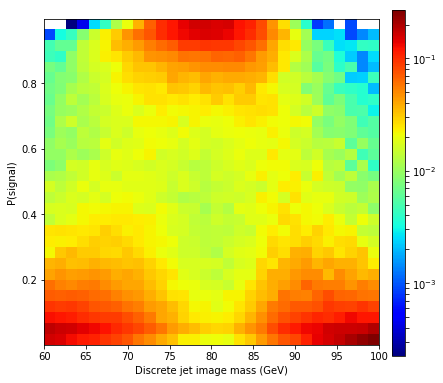

In [61]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 0], # mass
    yhat_cnn,
    xlabel='Discrete jet image mass (GeV)',
    ylabel='P(signal)',
)

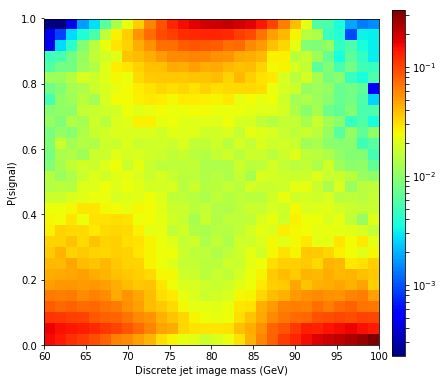

In [243]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 0], # mass
    yhat_lcn,
    xlabel='Discrete jet image mass (GeV)',
    ylabel='P(signal)',
)

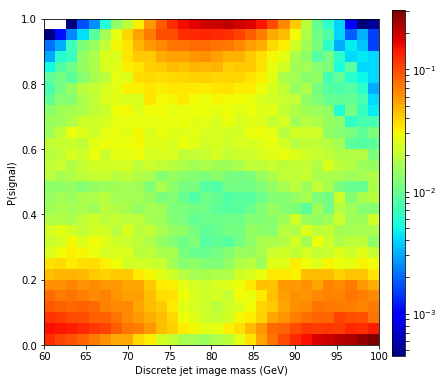

In [244]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 0], # mass
    yhat_dense,
    xlabel='Discrete jet image mass (GeV)',
    ylabel='P(signal)',
)

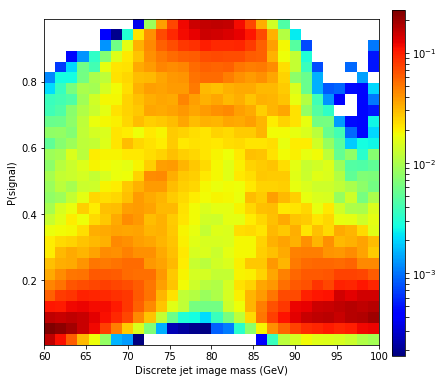

In [245]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 0], # mass
    yhat_baseline,
    xlabel='Discrete jet image mass (GeV)',
    ylabel='P(signal)',
)

### Tau_21

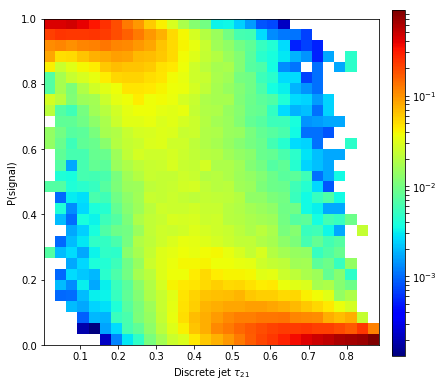

In [246]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 1], # tau21
    yhat_cnn,
    xlabel=r'Discrete jet $\tau_{21}$',
    ylabel='P(signal)',
)

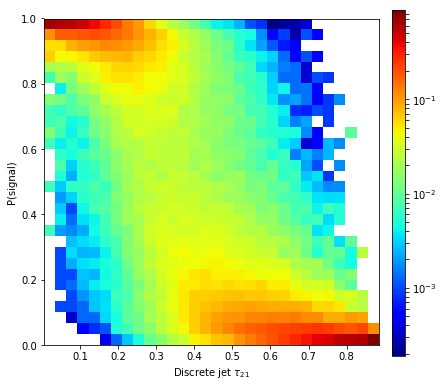

In [247]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 1], # tau21
    yhat_lcn,
    xlabel=r'Discrete jet $\tau_{21}$',
    ylabel='P(signal)',
)

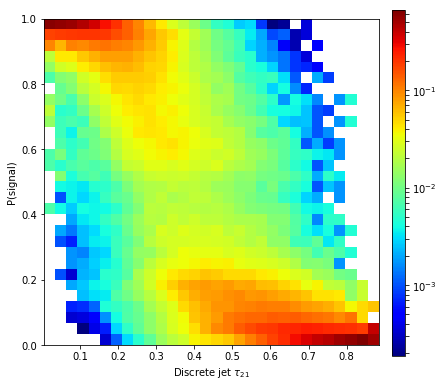

In [248]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 1], # tau21
    yhat_dense,
    xlabel=r'Discrete jet $\tau_{21}$',
    ylabel='P(signal)',
)

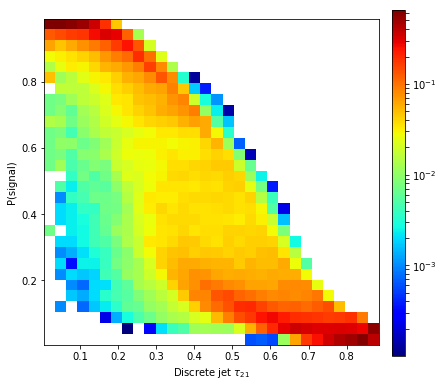

In [249]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 1], # tau21
    yhat_baseline,
    xlabel=r'Discrete jet $\tau_{21}$',
    ylabel='P(signal)',
)

### Delta R

/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in divide


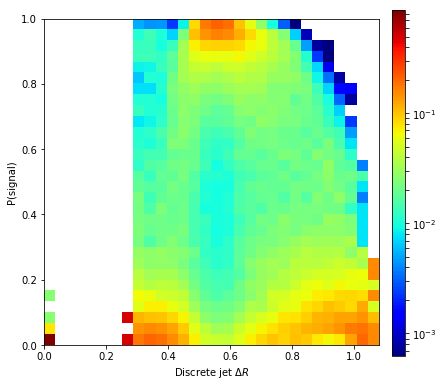

In [250]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 2], # deltaR
    yhat_cnn,
    xlabel=r'Discrete jet $\Delta R$',
    ylabel='P(signal)',
)

/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in divide


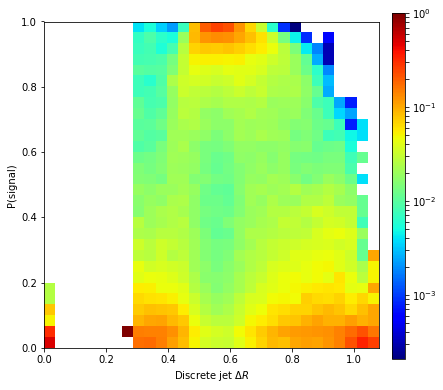

In [251]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 2], # deltaR
    yhat_lcn,
    xlabel=r'Discrete jet $\Delta R$',
    ylabel='P(signal)',
)

/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in divide


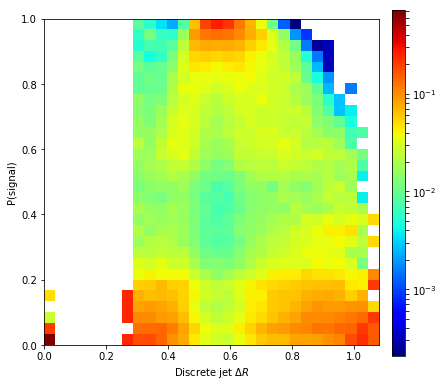

In [252]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 2], # deltaR
    yhat_dense,
    xlabel=r'Discrete jet $\Delta R$',
    ylabel='P(signal)',
)

/home/lukedeo/.venvwrp/micky-nb/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in divide


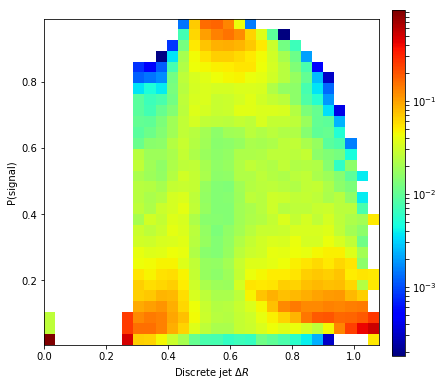

In [253]:
plot_output_vs_kin(
    scaler.inverse_transform(features_test)[:, 2], # deltaR
    yhat_baseline,
    xlabel=r'Discrete jet $\Delta R$',
    ylabel='P(signal)',
)

Sometimes, however, it is not a good idea to have your network learn the mass of a jet and use that to classify jets. In that case, in fact, the network will successfully suppress all jets outside of the signal-like mass window and sculpt the mass of the background to look like a signal peak. 

What we would like to be able to do, instead, is to have a classifier that is insensitive to mass, and that reduced the background across the entire mass spectrum. 

For reference, see: C. Shimmin et al., <a href="https://arxiv.org/abs/1703.03507">Decorrelated Jet Substructure Tagging using Adversarial Neural Networks</a>.

# Training a GAN (<a href="https://arxiv.org/pdf/1704.00028.pdf">WGAN-GP</a>) on jet images

WGAN-GP = a type of GAN that minimizes the Wasserstein distance between the target and generated distributions and enforces the Lipschitz contraint by penalizing the norm of the gradient instead of clipping weights.

In [89]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K

In [90]:
BATCH_SIZE = 100

# The training ratio is the number of discriminator updates per generator
# update. The paper uses 5.
TRAINING_RATIO = 5
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper

Define new custom loss functions not included among the standard keras ones:

In [91]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


def gradient_penalty_loss(y_true, y_pred, averaged_samples,
                          gradient_penalty_weight):
    gradients = K.gradients(K.sum(y_pred), averaged_samples)
    gradient_l2_norm = K.sqrt(K.sum(K.square(gradients)))
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    return gradient_penalty

In [92]:
def make_generator():
    """Creates a generator model that takes a 100-dimensional latent prior and 
    converts to size 25 x 25 x 1"""

    z = Input(shape=(100, ))
    
    x = Dense(1024, input_dim=100)(z)
    x = LeakyReLU()(x)

    x = Dense(128 * 7 * 7)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((7, 7, 128))(x)

    x = Conv2DTranspose(128, (5, 5), strides=2, padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = LeakyReLU()(x)

    x = Convolution2D(64, (5, 5), padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=2, padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = LeakyReLU()(x)

    y = Convolution2D(1, (4, 4), padding='valid', activation='relu')(x)

    return Model(z, y)

In [93]:
def make_discriminator():

    x = Input(shape=(25, 25, 1))
    
    h = Convolution2D(64, (5, 5), padding='same')(x)
    h = LeakyReLU()(h)

    h = Convolution2D(128, (5, 5), kernel_initializer='he_normal',
                      strides=2)(h)
    h = LeakyReLU()(h)

    h = Convolution2D(256, (5, 5), kernel_initializer='he_normal',
                      padding='same', strides=2)(h)
    h = LeakyReLU()(h)

    h = Flatten()(h)
    h = Dense(1024, kernel_initializer='he_normal')(h)
    h = LeakyReLU()(h)

    y = Dense(1, kernel_initializer='he_normal')(h)

    return Model(x, y)

Build individual models:

In [96]:
generator = make_generator()
discriminator = make_discriminator()

Build connected model with only generator trainable:

In [97]:
discriminator.trainable = False
z = Input(shape=(100, ))
generator_model = Model(z, discriminator(generator(z)))
# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                        loss=wasserstein_loss)

Build connected model with only discriminator trainable:

In [98]:
discriminator.trainable = True
generator.trainable = False

In [94]:
class RandomWeightedAverage(_Merge): # used for gradient norm penalty

    def _merge_function(self, inputs):
        weights = K.random_uniform((K.shape(inputs[0])[0], 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [99]:
real_samples = Input(shape=(25, 25, 1))
z = Input(shape=(100,))
fake_samples = generator(z)

critic_out_fake = discriminator(fake_samples)
critic_out_real = discriminator(real_samples)

# generate weighted-averages of real and generated
# samples, to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples, fake_samples])

# running them thru critic to get the gradient norm for the GP loss.
averaged_samples_out = discriminator(averaged_samples)

# The gradient penalty loss function requires the input averaged samples
def gp_loss(y_true, y_pred):
    return gradient_penalty_loss(
        y_true, y_pred,
        averaged_samples=averaged_samples,
        gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT
    )

discriminator_model = Model(
    inputs=[real_samples, z],
    outputs=[critic_out_real, critic_out_fake, averaged_samples_out]
)

# We use the Adam paramaters from Gulrajani et al.
discriminator_model.compile(
    optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
    loss=[wasserstein_loss, wasserstein_loss, gp_loss]
)

In [100]:
# positive_y is the label vector for real samples, with value 1.
# negative_y is the label vector for generated samples, with value -1.
# dummy_y vector is passed to the gradient_penalty loss function and is
# not used.

positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

In [101]:
# do a little bit of scaling for stability
X_train = np.expand_dims(np.squeeze(images_train[:30000]) / 100, -1)

In [260]:
overall_disc_loss = []

for epoch in range(200): # train for 200 iterations

    # at each epoch, shuffle the training set to get new samples
    np.random.shuffle(X_train)
    print "Epoch: ", epoch
    print "Number of batches: ", int(X_train.shape[0] // BATCH_SIZE)
    discriminator_loss = []
    generator_loss = []

    # we'll need this many samples per critic update
    critic_nb_samples = BATCH_SIZE * TRAINING_RATIO

    # loop through batches
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        X_critic = X_train[i * critic_nb_samples:(i + 1) * critic_nb_samples]

        # critic gets trained 5 times more per iteration than the generator
        for j in range(TRAINING_RATIO):
            X_minibatch = X_critic[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]

            # generate new input noise
            noise = np.random.rand(BATCH_SIZE, 100).astype(np.float32)

            # train the discriminator (or critic)
            disc_loss = discriminator_model.train_on_batch(
                [X_minibatch, noise],
                [positive_y, negative_y, dummy_y]
            )
            discriminator_loss.append(disc_loss)
    
        critic_score = np.array(discriminator_loss)[:, 0]
        if i % 10 == 0:
            print 'critic score =', critic_score.mean()
        overall_disc_loss.extend(critic_score.tolist())
        # train the generator
        gen_loss = generator_model.train_on_batch(
            np.random.rand(BATCH_SIZE, 100),
            positive_y
        )
        generator_loss.append(gen_loss)

Epoch:  0
Number of batches:  300
critic score = 0.00151446
critic score = 0.00177793
critic score = 0.00153065
critic score = 0.00159332
critic score = 0.00163725
critic score = 0.00175181
Epoch:  1
Number of batches:  300
critic score = 1.95312e-05
critic score = 0.00115547
critic score = 0.00140326
critic score = 0.00168951
critic score = 0.00162001
critic score = 0.00162208
Epoch:  2
Number of batches:  300
critic score = 0.00291257
critic score = 0.00173013
critic score = 0.00161283
critic score = 0.00150917
critic score = 0.00162098
critic score = 0.001567
Epoch:  3
Number of batches:  300
critic score = 0.00157771
critic score = 0.00117611
critic score = 0.00132732
critic score = 0.00164625
critic score = 0.00148376
critic score = 0.00176319
Epoch:  4
Number of batches:  300
critic score = 0.00420777
critic score = 0.00179685
critic score = 0.00171872
critic score = 0.0015852
critic score = 0.00151661
critic score = 0.00155593
Epoch:  5
Number of batches:  300
critic score = 0.0

KeyboardInterrupt: 

In [329]:
# discriminator.save_weights('./models/wgan-discriminator.h5')
# generator.save_weights('./models/wgan-generator.h5')

Load pre-trained wights:

In [104]:
discriminator.load_weights('./models/wgan-discriminator.h5')
generator.load_weights('./models/wgan-generator.h5')

Now that we have a trained GAN, we can see if it actually works and what it produces. We can now get rid of the critic (discriminator) and focus only on the part that we really care about, the generator. Let's execute a forward pass on the generator.

In [108]:
# input noise that will be transformed into jet images
noise = np.random.rand(1000, 100).astype(np.float32)

In [109]:
# produce some jet images from the generator!
fake_jets = generator.predict(noise, batch_size=BATCH_SIZE, verbose=True)

# rescale energies and remove redundant dimension for grayscale channel
fake_jets = np.squeeze(fake_jets * 100)

1000/1000 [==============================] - 10s 10ms/step


Let's look at some GAN-generated jet images!

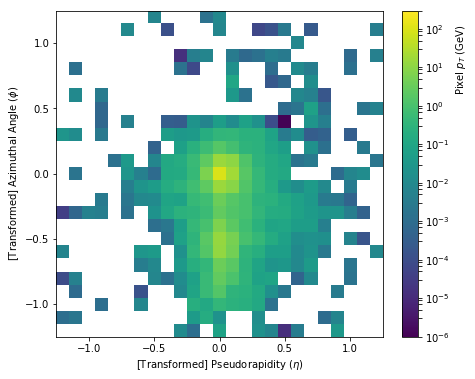

In [110]:
plot_jet_image(fake_jets.mean(0))

We can also look at the difference between the average generated image and the average real image to identify parts of the image that are not well-captured by the GAN and might need improvement. Green pixels are more strongly activated, on average, in fake images, while purple pixels are more strongly activated in background images.

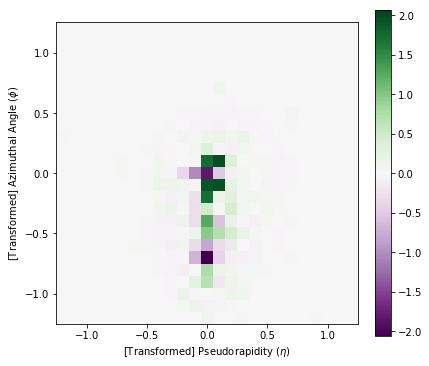

In [112]:
plot_diff_jet_image(fake_jets.mean(0) - images.mean(0), cmap='PRGn')

There are multiple ways of imporving this training, such as conditioning on class or attributes, using minibatch discrimination, enforcing physical constraints, etc.